In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import cv2



In [3]:
!unzip '/content/Data-20240213T113940Z-001.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Data/seg_pred/5004.jpg  
  inflating: Data/seg_pred/3552.jpg  
  inflating: Data/seg_pred/4894.jpg  
  inflating: Data/seg_pred/23592.jpg  
  inflating: Data/seg_pred/324.jpg   
  inflating: Data/seg_pred/4804.jpg  
  inflating: Data/seg_pred/3433.jpg  
  inflating: Data/seg_pred/23664.jpg  
  inflating: Data/seg_pred/5179.jpg  
  inflating: Data/seg_pred/522.jpg   
  inflating: Data/seg_pred/5067(1).jpg  
  inflating: Data/seg_pred/23834.jpg  
  inflating: Data/seg_pred/3495.jpg  
  inflating: Data/seg_pred/3322.jpg  
  inflating: Data/seg_pred/513.jpg   
  inflating: Data/seg_pred/23742.jpg  
  inflating: Data/seg_pred/9139.jpg  
  inflating: Data/seg_pred/23863.jpg  
  inflating: Data/seg_pred/9235.jpg  
  inflating: Data/seg_pred/2355.jpg  
  inflating: Data/seg_pred/3508.jpg  
  inflating: Data/seg_pred/4743.jpg  
  inflating: Data/seg_pred/5249.jpg  
  inflating: Data/seg_pred/23768.jpg  
  inflating: Data/seg_pred/2

In [4]:
data_path='/content/Data'
pred='/content/Data/seg_pred'
test_data='/content/Data/seg_test'
train_data='/content/Data/seg_train'


In [5]:
class_name=[]

for folder_name in os.listdir(train_data):
  class_name.append(folder_name)

In [ ]:
class_name

['street', 'mountain', 'forest', 'sea', 'glacier', 'buildings']

In [6]:
train =[]
labels=[]

for i in range (len(class_name)):
  class_n=class_name[i]
  image_names=os.listdir(f'{train_data}/{class_n}')
  for image_name in image_names:
    image_path=(f'{train_data}/{class_n}/{image_name}')
    train.append(image_path)
    labels.append(i)

In [7]:
class_name1=[]
for folder_name in os.listdir(test_data):
  class_name1.append(folder_name)


test=[]
labels=[]

for i in range (len(class_name)):
  class_n1=class_name1[i]
  image_names=os.listdir(f'{test_data}/{class_n1}')
  for image_name in image_names:
    image_path=(f'{test_data}/{class_n1}/{image_name}')
    test.append(image_path)
    labels.append(i)

In [8]:
data_transform={
    'train':transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),transforms.Normalize((0.3,0.3,0.3),(0.3,0.3,0.3))]),
    'test':transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.3,0.3,0.3),(0.3,0.3,0.3))]),
    'pred':transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.3,0.3,0.3),(0.3,0.3,0.3))])

}

In [9]:
image_dataset={
    'train':torchvision.datasets.ImageFolder(train_data,transform=data_transform['train']),
    'test':torchvision.datasets.ImageFolder(train_data,transform=data_transform['test']),

}


In [10]:
num_epochs=5
batch_size=8
num_class=6
learning_rate=0.001
shuffle=True

In [11]:
import random
total_length=len(image_dataset['train'])
train_size=int(0.8*total_length)
val_size=int(total_length-train_size)

train_indices=random.sample(range(total_length),train_size)
train_dataset=torch.utils.data.Subset(image_dataset['train'],train_indices)
val_indices=[i for i in range(total_length) if i not in train_indices ]
val_dataset=torch.utils.data.Subset(image_dataset['train'],val_indices)

In [12]:
data_loaders={
    'train':DataLoader(train_dataset,batch_size=batch_size,shuffle=shuffle),
    'test':DataLoader(image_dataset['test'],batch_size=batch_size,shuffle=shuffle),
    'val':DataLoader(val_dataset,batch_size=batch_size,shuffle=shuffle),
}

In [13]:
n_batchs=len(data_loaders['train'])//batch_size
n_batchs

24

In [14]:
random_sampler = torch.utils.data.RandomSampler(data_loaders['train'], replacement=False)
random_dataloader = torch.utils.data.DataLoader(data_loaders['train'].dataset, batch_size=batch_size, sampler=random_sampler)


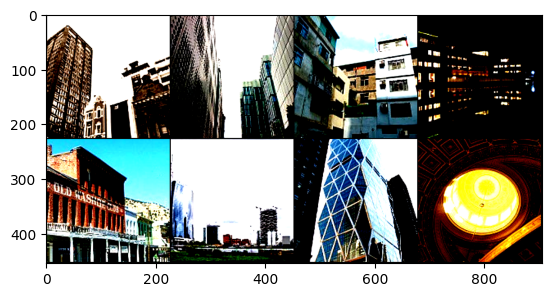

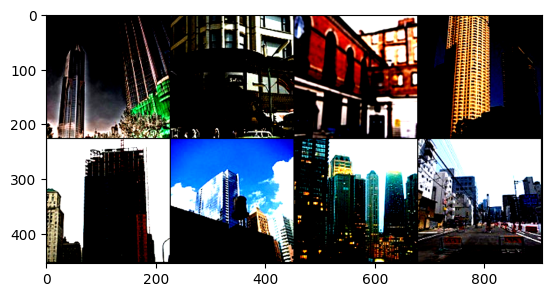

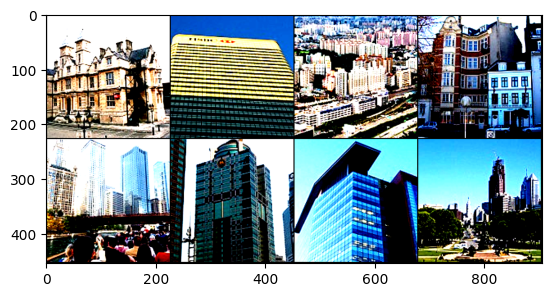

In [15]:
import random
import matplotlib.pyplot as plt
def batch_grid(data_loader):
  for _ in range(3):
    batch_index=random.randint(0,n_batchs-1)
    images,_ = next(iter(data_loader))
    grid = torchvision.utils.make_grid(images, nrow=4, padding=2)

    plt.imshow(grid.permute(1, 2, 0))
    plt.show()
batch_grid(random_dataloader)

In [16]:
class Landscape(nn.Module):
  def __init__(self):
    super(Landscape,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5,padding=2,stride=1)
    self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2,stride=2)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=1)
    self.fc1=nn.Linear(128*111*111,128)
    self.fc2=nn.Linear(128,256)
    self.out=nn.Linear(256,6)
    self.drop_out=nn.Dropout(p=0.5)

  def forward(self,X):

    X=F.relu(self.conv1(X))


    X=F.relu(self.conv2(X))

    X=self.pool(X)

    X=X.view(X.size(0),-1)

    X=self.drop_out(X)
    X= F.relu(self.fc1(X))
    X= F.relu(self.fc2(X))
    X=self.out(X)
    return X




In [17]:
model=Landscape()

In [18]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [19]:
total_step = len(data_loaders['train'])
total_step

199

In [20]:
loss_list = []
acc_list = []
val_loss_list = []

trained_models=[]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loaders['train']):
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        acc_list.append(correct / total)


        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    trained_models.append(model)

    with torch.no_grad():
        val_loss = 0
        for i, (images, labels) in enumerate(data_loaders['val']):
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

        val_loss /= len(data_loaders['val'])
        val_loss_list.append(val_loss)

        print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss))


Epoch [1/5], Step [100/199], Loss: 0.0000, Accuracy: 100.00%
Epoch [1/5], Validation Loss: 0.0000
Epoch [2/5], Step [100/199], Loss: 0.0000, Accuracy: 100.00%
Epoch [2/5], Validation Loss: 0.0000
Epoch [3/5], Step [100/199], Loss: 0.0000, Accuracy: 100.00%
Epoch [3/5], Validation Loss: 0.0000
Epoch [4/5], Step [100/199], Loss: 0.0000, Accuracy: 100.00%
Epoch [4/5], Validation Loss: 0.0000
Epoch [5/5], Step [100/199], Loss: 0.0000, Accuracy: 100.00%
Epoch [5/5], Validation Loss: 0.0000


In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in data_loaders['test']:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy score: {} %'.format((correct / total) * 100))

Test Accuracy score: 100.0 %


In [22]:
model_list = list(zip(trained_models, val_loss_list))

In [27]:
unlabeled_class='unlabeled'
unlabeled_folder= os.path.join(pred,'unlabeled')
os.makedirs(unlabeled_folder,exist_ok=True)



In [28]:
import shutil


for filename in os.listdir(pred):
    if os.path.isfile(os.path.join(pred, filename)):
        shutil.move(os.path.join(pred, filename), unlabeled_folder)

In [31]:
unlabeled_dataset = torchvision.datasets.ImageFolder(root=pred, transform=data_transform['pred'])

In [33]:
pred_loader =  torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

In [34]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in pred_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy score: {} %'.format((correct / total) * 100))

Test Accuracy score: 100.0 %


In [43]:
lowest_val_loss= min(val_loss_list)
best_model_index=val_loss_list.index(lowest_val_loss)
best_model=model_list[best_model_index]


torch.save(best_model, "Landscape_Classification.pth")

In [44]:
model2=torch.load("Landscape_Classification.pth")